## Income Risks Estimation 

This noteobok contains the following

 - Estimation functions of time-varying income risks for an integrated moving average process of income/earnings
 - It allows for different assumptions about expectations, ranging from rational expectation to alternative assumptions. 

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import copy as cp

In [176]:
## class of integrated moving average process, trend/cycle process allowing for serial correlation transitory shocks
class IMAProcess:
    '''
    inputs
    ------
    t: int, number of periods of the series
    process_para, dict, includes 
       - ma_coeffs: size f q for MA(q),  moving average coeffcients of transitory shocks. q = 0 by default.
       - sigmas:  size of t x 2, draws of permanent and transitory risks from time varying volatility 
    '''
    def __init__(self,
                 t = 100,
                 n_periods = np.array([1]),
                 ma_coeffs = np.ones(1),
                 sigmas = np.ones([2,100]),
                ):
        #self.process_para = process_para
        self.ma_coeffs = ma_coeffs
        self.ma_q = self.ma_coeffs.shape[0]
        self.t = t
        self.sigmas =sigmas
        self.n_periods = n_periods
    
    ## auxiliary function for ma cum sum
    def cumshocks(self,
                  shocks,
                  ma_coeffs):
        cum = []
        for i in range(len(shocks)):
            #print(shocks[i])
            #print(sum([ma_coeffs[back]*shocks[i-back] for back in range(len(ma_coeffs))]))
            cum.append(sum([ma_coeffs[back]*shocks[i-back] for back in range(len(ma_coeffs))]))
        return np.array(cum)         
    
    def SimulateSeries(self,
                      n_sim = 100):
        t = self.t 
        ma_coeffs = self.ma_coeffs
        sigmas = self.sigmas
        ma_q = self.ma_q 
                 
        p_draws = np.multiply(np.random.randn(n_sim*t).reshape([n_sim,t]), 
                              np.tile(sigmas[0,:],[n_sim,1]))  # draw permanent shocks
        t_draws = np.multiply(np.random.randn(n_sim*t).reshape([n_sim,t]), 
                              np.tile(sigmas[1,:],[n_sim,1]))  ## draw one-period transitory shocks 
        t_draws_cum = np.array( [self.cumshocks(shocks = t_draws[i,:],
                                                ma_coeffs = ma_coeffs) 
                                 for i in range(n_sim)]
                              )
        series = np.cumsum(p_draws,axis = 1) + t_draws_cum 
        self.simulated = series
        return self.simulated 
       
    def SimulatedMoments(self):
        series = self.simulated 
        
        ## the first difference 
        diff = np.diff(series,axis=1)
        
        ## moments of first diff
        mean_diff = np.mean(diff,axis = 0)
        varcov_diff = np.cov(diff.T)
        
        self.SimMoms = {'Mean':mean_diff,
                       'Var':varcov_diff}
        return self.SimMoms
    
    def TimeAggregate(self,
                      n_periods = 1):
        simulated = self.simulated
        t = self.t
        
        simulated_agg = np.array([np.sum(simulated[:,i-n_periods:i],axis=1) for i in range(n_periods,t+1)]).T
        self.simulated_agg = simulated_agg
        return self.simulated_agg
    
    def SimulateMomentsAgg(self):
        series_agg = self.simulated_agg 
        
        ## the first difference 
        diff = np.diff(series_agg,
                       axis = 1)
        ## moments of first diff
        mean_diff = np.mean(diff,axis = 0)
        varcov_diff = np.cov(diff.T)
        
        self.SimAggMoms = {'Mean':mean_diff,
                           'Var':varcov_diff}
        return self.SimAggMoms
    
    def ComputeGenMoments(self):
        ## parameters 
        t = self.t 
        ma_coeffs = self.ma_coeffs
        sigmas = self.sigmas
        p_sigmas = sigmas[0,:]
        t_sigmas = sigmas[1,:]
        ma_q = self.ma_q 
        
        ## generalized moments 
        mean_diff = np.zeros(t)[1:] 
        ## varcov is basically the variance covariance of first difference of income of this IMA(q) process
        ## Cov(delta y_t - delta y_{t+k}) forall k for all t
        varcov_diff = np.asmatrix( np.zeros((t)**2).reshape([t,t]) )
        
        for i in range(t):
            autocovf_this = p_sigmas[i]**2 + t_sigmas[i]**2 + t_sigmas[i-1]**2
            varcov_diff[i,i] = autocovf_this
            try:
                varcov_diff[i,i+1] = - t_sigmas[i]**2
                varcov_diff[i+1,i] = - t_sigmas[i]**2            
            except:
                pass
        varcov_diff = varcov_diff[1:,1:]
        self.GenMoms = {'Mean':mean_diff,
                       'Var':varcov_diff}
        return self.GenMoms
    
    def GetDataMoments(self,
                      data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    def GetDataMomentsAgg(self,
                          data_moms_agg_dct):
        self.data_moms_agg_dct = data_moms_agg_dct    
        
    def ObjFunc(self,
                para):
        data_moms_dct = self.data_moms_dct
        t = self.t
        ma_coeffs,sigmas = para
        self.t = t
        self.ma_coeffs = ma_coeffs
        self.sigmas = sigmas
        model_moms_dct = self.ComputeGenMoments() 
        model_moms = np.array([model_moms_dct[key] for key in ['Var']]).flatten()
        data_moms = np.array([data_moms_dct[key] for key in ['Var']]).flatten()
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
        
    def EstimatePara(self,
                     method = 'CG',
                     bounds = None,
                     para_guess =(1,
                                  np.random.uniform(0,1,100).reshape(2,50)),
                     options = {'disp':True}):
        
        para_est = minimize(self.ObjFunc,
                            x0 = para_guess,
                            method = method,
                            bounds = bounds,
                            options = options)['x']
        
        self.para_est = para_est
        return self.para_est    
    
    def ObjFuncSim(self,
                para_sim):
        data_moms_dct = self.data_moms_dct
        t = self.t
        ma_coeffs,sigmas = para_sim
        self.t = t
        self.ma_coeffs = ma_coeffs
        self.sigmas = sigmas
        model_series_sim = self.SimulateSeries() 
        model_moms_dct = self.SimulatedMoments() 
        model_moms = np.array([model_moms_dct[key] for key in ['Var']]).flatten()
        data_moms = np.array([data_moms_dct[key] for key in ['Var']]).flatten()
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
        
    def EstimateParabySim(self,
                     method = 'CG',
                     bounds = None,
                     para_guess =(np.array([1]),
                                  np.random.uniform(0,1,100).reshape(2,50)),
                     options = {'disp':True}):
        
        para_est_sim = minimize(self.ObjFuncSim,
                            x0 = para_guess,
                            method = method,
                            bounds = bounds,
                            options = options)['x']
        
        self.para_est_sim = para_est_sim
        return self.para_est_sim  
    
    def ObjFuncAgg(self,
                   para_agg):
        data_moms_agg_dct = self.data_moms_agg_dct
        t = self.t
        ma_coeffs,sigmas = para_agg
        self.t = t
        self.ma_coeffs = ma_coeffs
        self.sigmas = sigmas
        model_series_sim = self.SimulateSeries() 
        model_moms_dct = self.SimulatedMoments() 
        model_series_agg = self.TimeAggregate(n_periods = 12)
        model_moms_agg_dct = self.SimulateMomentsAgg()
        model_moms = np.array([model_moms_agg_dct[key] for key in ['Var']]).flatten()
        data_moms = np.array([data_moms_agg_dct[key] for key in ['Var']]).flatten()
        if len(model_moms) > len(data_moms):
            n_burn = len(model_moms) - len(data_moms)
            model_moms = model_moms[n_burn:]
        if len(model_moms) < len(data_moms):
            n_burn = -(len(model_moms) - len(data_moms))
            data_moms = data_moms[n_burn:]
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
    
    def EstimateParaAgg(self,
                        method = 'CG',
                        bounds = None,
                        para_guess =(np.array([1]),
                                     np.random.uniform(0,1,100).reshape(2,50)),
                        options = {'disp':True}):
        
        para_est_agg = minimize(self.ObjFuncAgg,
                                x0 = para_guess,
                                method = method,
                                bounds = bounds,
                                options = options)['x']
        
        self.para_est_agg = para_est_agg
        return self.para_est_agg  
    
    def Autocovar(self,
                  step = 1):
        cov_var = self.SimMoms['Var']
        if step >= 0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)])
        if step < 0:
            autovar = np.array([cov_var[i+step,i] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovar = autovar
        return self.autovar
    
    def AutocovarComp(self,
                  step = 1):
        cov_var = self.GenMoms['Var']
        if step >= 0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)])
        if step < 0:
            autovar = np.array([cov_var[i+step,i] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovarGen = autovar
        return self.autovarGen
    
    def AutocovarAgg(self,
                     step = 0):
        cov_var = self.SimAggMoms['Var']
        if step >=0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)]) 
        if step < 0:
            autovar = np.array([cov_var[i,i+step] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovar = autovar
        self.autovaragg = autovar
        return self.autovaragg 

In [177]:
## debugging test of the data 

t = 50
ma_nosa = np.array([1])
p_sigmas = np.arange(t)  # sizes of the time-varying permanent volatility 
p_sigmas_rw = np.ones(t) # a special case of time-invariant permanent volatility, random walk 
p_sigmas_draw = np.random.uniform(0,1,t) ## allowing for time-variant shocks 

pt_ratio = 0.33
t_sigmas = pt_ratio * p_sigmas_draw # sizes of the time-varyingpermanent volatility
sigmas = np.array([p_sigmas_draw,
                   t_sigmas])

dt = IMAProcess(t = t,
                ma_coeffs = ma_nosa,
                sigmas = sigmas)
sim_data = dt.SimulateSeries(n_sim = 5000)
sim_moms = dt.SimulatedMoments()

In [178]:
## get the computed moments 

comp_moms = dt.ComputeGenMoments()

av_comp = comp_moms['Mean']
cov_var_comp = comp_moms['Var']
var_comp = dt.AutocovarComp(step=0) #np.diagonal(cov_var_comp)
autovarb1_comp = dt.AutocovarComp(step=-1)  #np.array([cov_var_comp[i,i+1] for i in range(len(cov_var_comp)-1)]) 

In [179]:
## get the simulated moments 
av = sim_moms['Mean']
cov_var = sim_moms['Var']
var = dt.Autocovar(step = 0)   #= np.diagonal(cov_var)
autovarb1 = dt.Autocovar(step = -1) #np.array([cov_var[i,i+1] for i in range(len(cov_var)-1)]) 

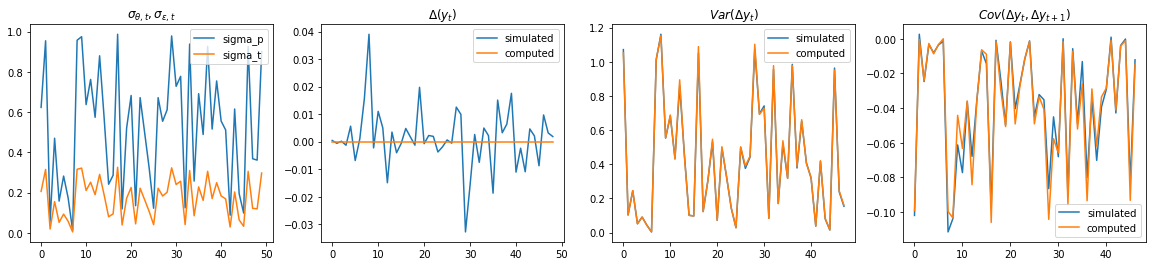

In [180]:
## plot simulated moments of first diff 

plt.figure(figsize=((20,4)))

plt.subplot(1,4,1)
plt.title(r'$\sigma_{\theta,t},\sigma_{\epsilon,t}$')
plt.plot(p_sigmas_draw,label='sigma_p')
plt.plot(t_sigmas,label='sigma_t')
plt.legend(loc=0)

plt.subplot(1,4,2)
plt.title(r'$\Delta(y_t)$')
plt.plot(av,label='simulated')
plt.plot(av_comp,label='computed')
plt.legend(loc=0)

plt.subplot(1,4,3)
plt.title(r'$Var(\Delta y_t)$')
plt.plot(var,label='simulated')
plt.plot(var_comp,label='computed')
plt.legend(loc=0)

plt.subplot(1,4,4)
plt.title(r'$Cov(\Delta y_t,\Delta y_{t+1})$')
plt.plot(autovarb1,label='simulated')
plt.plot(autovarb1_comp,label='computed')
plt.legend(loc = 0)

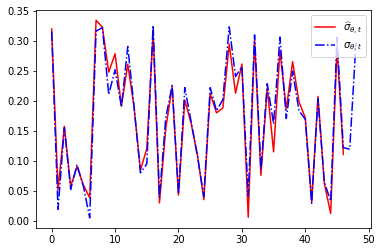

In [181]:
## robustness check if the transitory risks is approximately equal to the assigned level

sigma_t_est = np.array(np.sqrt(abs(autovarb1)))
plt.plot(sigma_t_est,'r-',label=r'$\widehat \sigma_{\theta,t}$')
plt.plot(t_sigmas[1:],'b-.',label=r'$\sigma_{\theta,t}$')
plt.legend(loc=1)

### Time Aggregation

In [182]:
## time aggregation 

sim_data = dt.SimulateSeries(n_sim = 1000)
agg_series = dt.TimeAggregate(n_periods = 2)
agg_series_moms = dt.SimulateMomentsAgg()

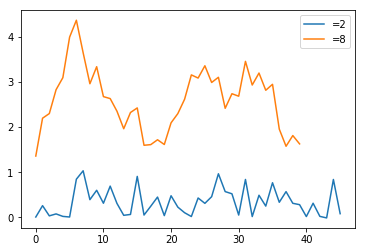

In [183]:
## difference times degree of time aggregation leads to different autocorrelation
for ns in np.array([2,8]):
    an_instance = cp.deepcopy(dt)
    series = an_instance.SimulateSeries(n_sim =500)
    agg_series = an_instance.TimeAggregate(n_periods = ns)
    agg_series_moms = an_instance.SimulateMomentsAgg()
    var_sim = an_instance.AutocovarAgg(step=0)
    var_b1 = an_instance.AutocovarAgg(step=-1)
    plt.plot(var_b1,label=r'={}'.format(ns))
plt.legend(loc=1)

In [184]:
## some fake data moments with alternative parameters

pt_ratio_fake = 0.6
t_sigmas = pt_ratio_fake * p_sigmas_draw # sizes of the time-varyingpermanent volatility
sigmas = np.array([p_sigmas_draw,
                   t_sigmas])

dt_fake = IMAProcess(t = t,
                     ma_coeffs = ma_nosa,
                     sigmas = sigmas)
data_fake = dt_fake.SimulateSeries(n_sim = 5000)
moms_fake = dt_fake.SimulatedMoments()

### Estimation

#### Estimation using computed moments 

In [206]:
## estimation of income risks 

dt_est = cp.deepcopy(dt)
dt_est.GetDataMoments(moms_fake)

In [207]:
para_est = dt_est.EstimatePara(method='CG')

Optimization terminated successfully.
         Current function value: 4.034694
         Iterations: 6
         Function evaluations: 72
         Gradient evaluations: 18


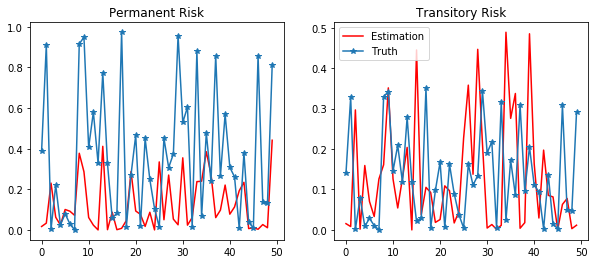

In [208]:
## check the estimation and true parameters 

fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est[1][0].T**2,'r-',label='Estimation')
plt.plot(dt_fake.sigmas[0]**2,'-*',label='Truth')


plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est[1][1].T**2,'r-',label='Estimation')
plt.plot(dt_fake.sigmas[1]**2,'-*',label='Truth')
plt.legend(loc=0)

#### Estimation using simulated moments 

In [209]:
para_est_sim = dt_est.EstimateParabySim()

         Current function value: 8.424055
         Iterations: 1
         Function evaluations: 88
         Gradient evaluations: 19


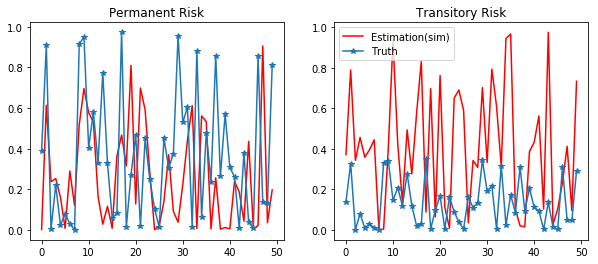

In [210]:
## check the estimation and true parameters

fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est_sim[1][0].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[0]**2,'-*',label='Truth')


plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est_sim[1][1].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[1]**2,'-*',label='Truth')
plt.legend(loc=0)

#### Estimation using time aggregated data

In [211]:
## get some fake aggregated data moments
moms_agg_fake = dt_fake.TimeAggregate()
moms_agg_dct_fake = dt_fake.SimulateMomentsAgg()

In [212]:
## estimation 
dt_est.GetDataMomentsAgg(moms_agg_dct_fake)
dt_est.EstimateParaAgg()

         Current function value: 75.094990
         Iterations: 2
         Function evaluations: 141
         Gradient evaluations: 32


array([array([0.99999999]),
       array([[0.6049832 , 0.20778227, 0.70176015, 0.81855626, 0.05639848,
        0.41874919, 0.56062754, 0.55015785, 0.4906266 , 0.78435619,
        0.37249748, 0.12376898, 0.92805962, 0.17189658, 0.82751365,
        0.2024496 , 0.4251238 , 0.09257717, 0.34842699, 0.62744183,
        0.28170525, 0.98174829, 0.82997247, 0.59205052, 0.79376293,
        0.64191098, 0.96154494, 0.84853736, 0.99407615, 0.46373524,
        0.27510095, 0.80989327, 0.23330408, 0.44118461, 0.10251004,
        0.99279534, 0.18899109, 0.73109068, 0.35079876, 0.6798774 ,
        0.7798891 , 0.75830019, 0.7250347 , 0.858241  , 0.95804861,
        0.93675135, 0.22154655, 0.9005536 , 0.13674714, 0.35520705],
       [0.46171215, 0.09687362, 0.36258874, 0.46178777, 0.71445738,
        0.82137361, 0.98878351, 0.12769518, 0.86424666, 0.52686662,
        0.86095174, 0.51087027, 0.32937582, 0.35610592, 0.34912576,
        0.89559648, 0.75837473, 0.10780598, 0.04417621, 0.68010607,
        0.24

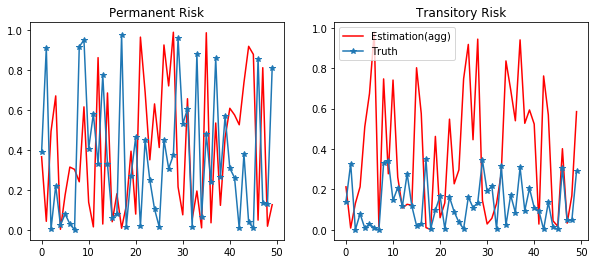

In [214]:
## check the estimation and true parameters

fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est_agg[1][0].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[0]**2,'-*',label='Truth')

plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est_agg[1][1].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[1]**2,'-*',label='Truth')
plt.legend(loc=0)